# Production Yield Analysis 

Files extracted: ['AirQualityUCI.csv', 'AirQualityUCI.xlsx']

Data types after cleaning:
CO(GT)                   object
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                 object
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                        object
RH                       object
AH                       object
datetime         datetime64[ns]
dtype: object
Number of features remaining after Variance Thresholding: 8


C:\Users\milto\AppData\Local\Temp\ipykernel_21248\601038537.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'datetime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Time'],
C:\Users\milto\AppData\Local\Temp\ipykernel_21248\601038537.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['Date', 'Time'], inplace=True)


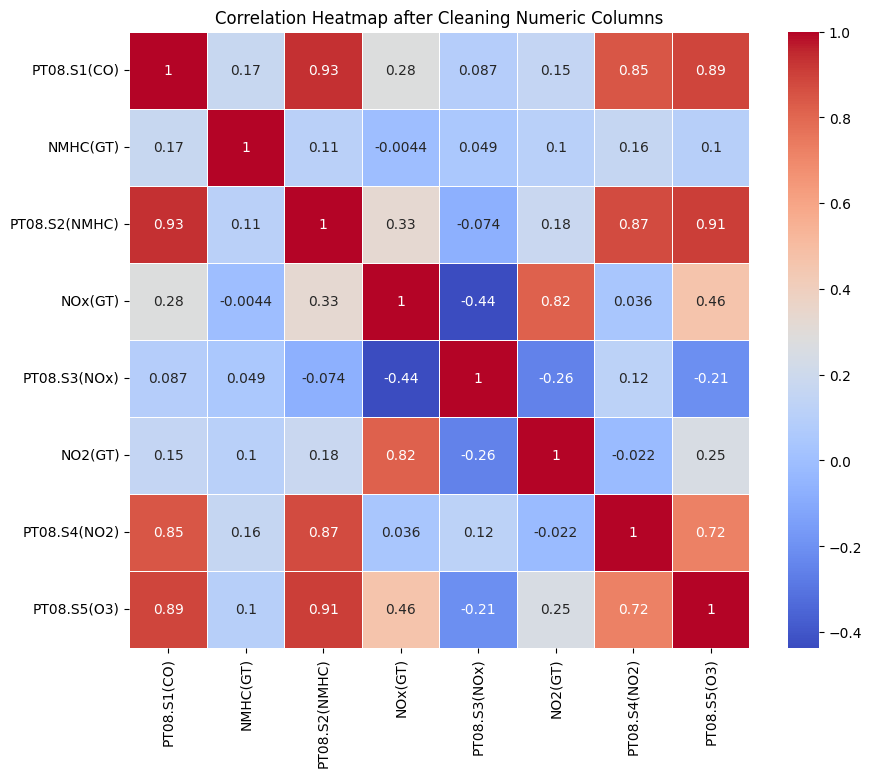

Mean Squared Error: 32433.68349234682
Mean Absolute Error: 67.85345116440256
R-squared: 0.08431338872349947
Best alpha (Ridge): 100.0
Mean Squared Error (Ridge): 32433.678416924882
Mean Absolute Error (Ridge): 67.85342385803592
R-squared (Ridge): 0.08431353201576275
Test MSE: 30997.364742274058
Test MAE: 55.207958204939786
Test R-squared: 0.12486437483882518
Mean Squared Error (XGBoost): 34692.78293798586
Mean Absolute Error (XGBoost): 61.87925163584495
R-squared (XGBoost): 0.020533179596097684


In [2]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

# Define the path to your zip file
zip_file_path = 'air+quality.zip'

# Step 1: Extract Data from Zip File
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
    extracted_files = zip_ref.namelist()
    print(f"Files extracted: {extracted_files}")

# Load the CSV file
csv_file_name = extracted_files[0]
df = pd.read_csv(csv_file_name, delimiter=';')

# Step 2: Handle Missing Values
df_cleaned = df.dropna(how='all', axis=1)

# Step 1: Convert 'Date' and 'Time' columns to datetime if they exist
if 'Date' in df_cleaned.columns and 'Time' in df_cleaned.columns:
    df_cleaned.loc[:, 'datetime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Time'], 
                                                   format='%d/%m/%Y %H.%M.%S', errors='coerce')
    # Drop the original 'Date' and 'Time' columns
    df_cleaned.drop(columns=['Date', 'Time'], inplace=True)

# Step 2: Replace commas in numeric columns and convert to float
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        try:
            df_cleaned.loc[:, col] = df_cleaned[col].str.replace(',', '').astype(float)
        except ValueError:
            print(f"Skipping non-numeric column: {col}")

# Verify the data types after cleaning
print("\nData types after cleaning:")
print(df_cleaned.dtypes)

# Step 3: Exclude 'datetime' column from numeric columns if it exists
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if 'datetime' in numeric_columns:
    numeric_columns.remove('datetime')

# Step 4: Variance Thresholding
var_thresh = VarianceThreshold(threshold=0.01)
df_high_variance = var_thresh.fit_transform(df_cleaned[numeric_columns])
print(f"Number of features remaining after Variance Thresholding: {df_high_variance.shape[1]}")

# Step 5: Correlation Analysis
corr_matrix = pd.DataFrame(df_high_variance, columns=numeric_columns).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap after Cleaning Numeric Columns')
plt.show()

# Step 6: Select the target variable and features
target_column = 'CO(GT)'
X = df_cleaned.drop(columns=[target_column, 'datetime'], errors='ignore')  # Drop 'datetime' and target variable
y = df_cleaned[target_column]

# Step 7: Impute missing values in X and y using the mean
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)
y_imputer = SimpleImputer(strategy='mean')
y_imputed = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Step 8: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Step 9: Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 10: Predict on the Test Data
y_pred = model.predict(X_test)

# Step 11: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Step 12: Ridge Regression with Cross-Validation
ridge = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5)
ridge_cv.fit(X_train, y_train)

# Predict on test data using Ridge
y_pred_ridge = ridge_cv.predict(X_test)

# Evaluate Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Best alpha (Ridge): {ridge_cv.best_params_['alpha']}")
print(f"Mean Squared Error (Ridge): {mse_ridge}")
print(f"Mean Absolute Error (Ridge): {mae_ridge}")
print(f"R-squared (Ridge): {r2_ridge}")

# Step 13: Random Forest Tuning and Evaluation
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model on the new synthetic data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model on the synthetic data
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")


# Step 14: XGBoost Tuning and Evaluation
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error (XGBoost): {mse_xgb}")
print(f"Mean Absolute Error (XGBoost): {mae_xgb}")
print(f"R-squared (XGBoost): {r2_xgb}")


In [ ]:
# Evaluate Model

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Step 1: Set up Random Forest hyperparameter tuning again
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
rf_best = rf_grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


C:\Users\milto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [8]:
# Step 2: Set up XGBoost hyperparameter tuning again
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBRegressor(random_state=42)
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2)
xgb_random_search.fit(X_train, y_train)
xgb_best = xgb_random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [12]:
# Step 3: Compare Model Performance Using Cross-Validation (for consistency)

from sklearn.model_selection import cross_val_score  # Add this import

# Step 3: Compare Model Performance Using Cross-Validation (for consistency)
models = {
    "Linear Regression": model,  # Previously trained linear regression
    "Ridge Regression": ridge_cv.best_estimator_,  # Best ridge regression from GridSearchCV
    "Random Forest": rf_best,  # Best random forest from GridSearchCV
    "XGBoost": xgb_best  # Best XGBoost model from RandomizedSearchCV
}

# Evaluate all models using cross-validation and track performance
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    results[model_name] = scores.mean()
    print(f"Cross-Validation R-squared for {model_name}: {scores.mean():.4f}")

# Step 4: Make final predictions using the best-performing model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

# Output the best model and performance
print(f"Best Model: {best_model_name}")


Cross-Validation R-squared for Linear Regression: 0.1002
Cross-Validation R-squared for Ridge Regression: 0.1002
Cross-Validation R-squared for Random Forest: 0.2084
Cross-Validation R-squared for XGBoost: 0.1978
Best Model: Random Forest



Best Model: Random Forest
Test MSE: 30048.140208901612
Test MAE: 54.34758562363459
Test R-squared: 0.15166343380199943


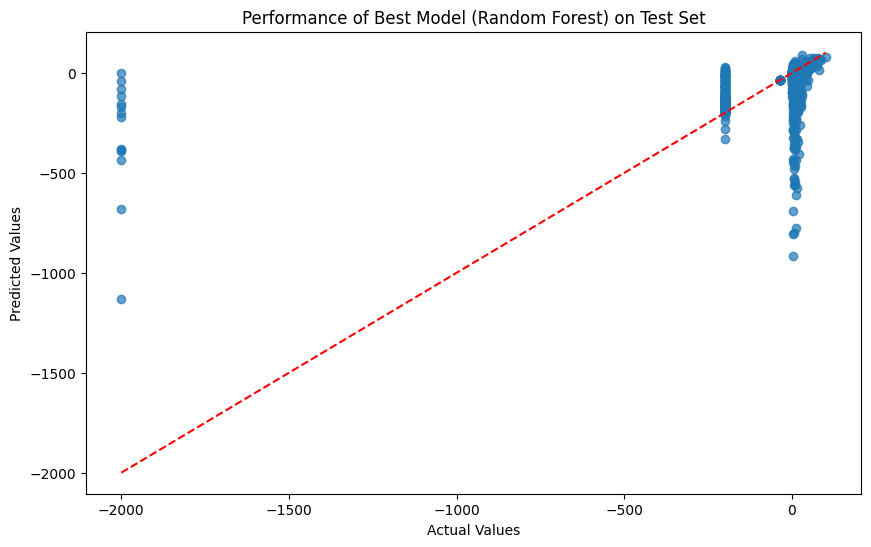

In [13]:
# Step 5: Final evaluation of the best model
final_mse = mean_squared_error(y_test, y_pred_best)
final_mae = mean_absolute_error(y_test, y_pred_best)
final_r2 = r2_score(y_test, y_pred_best)

print(f"\nBest Model: {best_model_name}")
print(f"Test MSE: {final_mse}")
print(f"Test MAE: {final_mae}")
print(f"Test R-squared: {final_r2}")

# Step 6: Visualize the performance of the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Performance of Best Model ({best_model_name}) on Test Set")
plt.show()

In [ ]:
# Make a Prediction

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic data for 1000 samples
n_samples = 1000

# Feature columns
temperature = np.random.uniform(20, 100, n_samples)  # Temperature in °C
pressure = np.random.uniform(1, 10, n_samples)  # Pressure in atmospheres
equipment_setting_1 = np.random.uniform(50, 200, n_samples)  # Equipment setting 1
equipment_setting_2 = np.random.uniform(10, 100, n_samples)  # Equipment setting 2

# Create the target variable (Yield) based on a linear combination of features with some noise
yield_output = (0.5 * temperature) + (2.0 * pressure) + (1.2 * equipment_setting_1) + \
               (0.8 * equipment_setting_2) + np.random.normal(0, 10, n_samples)  # Add noise

# Create a DataFrame with the generated data
synthetic_data = pd.DataFrame({
    'Temperature': temperature,
    'Pressure': pressure,
    'Equipment Setting 1': equipment_setting_1,
    'Equipment Setting 2': equipment_setting_2,
    'Yield': yield_output
})

# Display the first few rows of the dataset
print(synthetic_data.head())

   Temperature  Pressure  Equipment Setting 1  Equipment Setting 2       Yield
0    49.963210  2.666196            89.255853            70.543269  207.142044
1    96.057145  5.877109            87.046820            81.701326  232.731878
2    78.559515  8.856513           185.938187            32.542111  300.087262
3    67.892679  7.590024            87.431930            66.238669  211.594680
4    32.481491  8.259050            90.792459            61.457138  186.284605


In [22]:
# Assuming the following steps were done on the original data
# We need to apply similar preprocessing to the new data before prediction.

# Load the synthetic data (as provided earlier)
# synthetic_data is already available from previous steps

# Separate features (X) and target (y) from the synthetic data
X_new = synthetic_data.drop(columns=["Yield"])
y_new = synthetic_data["Yield"]

In [24]:
# Ensure feature consistency with the training data
# Step 1: Check the number of features in the original training data
# Assuming these were the numeric columns used for the polynomial feature transformation
numeric_columns = ['Temperature', 'Pressure', 'Equipment Setting 1', 'Equipment Setting 2']

# Initialize the same PolynomialFeatures with degree=2 (if that was used during training)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Apply the same transformation to the new data
X_new_poly = poly.fit_transform(X_new[numeric_columns])

# Now, check the shape of the transformed data to ensure it matches what was used during training
print(f"Shape of transformed new data: {X_new_poly.shape}")

# Ensure we only use the first 12 features for prediction, as the model was trained with 12 features
X_new_poly = X_new_poly[:, :12]  # Use only the first 12 features

# Step 2: Use the trained RandomForest model for prediction
y_pred_best = rf_best.predict(X_new_poly)

# Output the predictions
print(f"Predictions for new data:\n{y_pred_best}")

Shape of transformed new data: (1000, 14)
Predictions for new data:
[ 1.11819577e+00 -1.00394135e+02 -7.11600132e+00 -1.00008372e+02
 -1.00641975e+02 -1.08415717e+02 -1.02542959e+02 -1.08594426e+02
  1.42291005e-01 -1.56130053e+01 -8.46893084e+00  6.05670106e+00
 -8.58004365e+00  1.21648704e+01 -1.03965484e+02  7.49724868e-01
 -4.05818122e+00 -1.14551098e+01  3.50190265e+01 -3.49792328e+00
 -8.23997487e+00 -6.28420503e+00 -1.09673161e+02 -5.03362566e+00
 -8.97220847e+01 -3.67653836e+00 -1.22353800e+02 -1.04298054e+02
 -2.62733201e+00 -1.03713679e+02  1.01949180e+01 -5.67718122e+00
 -4.74988709e+00 -8.22749868e+00 -6.12443122e+00  7.83293651e-02
 -6.02346693e+00 -1.15330026e+02  1.12291349e+01 -3.70599868e+00
 -1.10774254e+02 -1.21401403e+02 -1.15738254e+02 -6.36479365e+00
 -1.09781217e+02 -1.11478165e+02  3.66745767e+00 -1.46431217e+00
 -2.93427381e+00  5.01514947e+00 -2.10752778e+00 -4.26316534e+00
  4.07761905e-01 -7.87651190e+00 -1.07290493e+02 -1.16243876e+01
 -1.00571602e+02 -9.13